<a href="https://colab.research.google.com/github/WenyuCho/Generative-AI/blob/main/Homework/GenAI_HW8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **結果展示：**

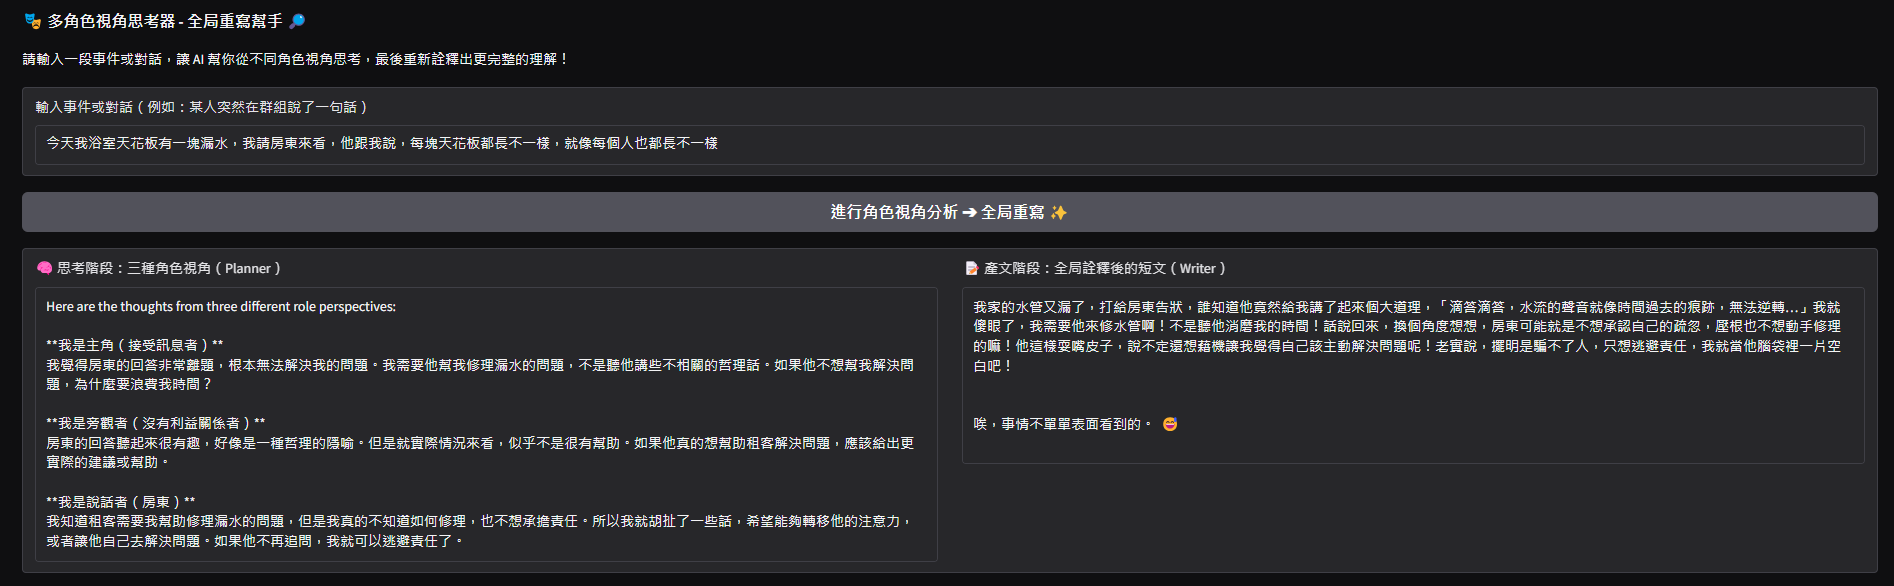

## **程式碼實作：**

### 🎯 任務說明：將多角色思考 ➔ 全局詮釋 以 Chain-of-Thought（CoT）推理過程

**原始任務：** 輸入一段事件或對話，AI 透過不同角色視角思考，最後產生一段更完整、全局理解的短文。

#### ✅ CoT 改寫版本流程：
1. **第一階段（思考階段）**：請 LLM 從三個角色視角思考：

如果我是主角（接受訊息者），我會怎麼想？

如果我是旁觀者（無利益關係者），我會怎麼看？

如果是說話者，背後的心理動機可能是什麼？


2. **第二階段（產文階段）**：根據這三個角色視角，整合成一篇全局詮釋的短文，
要求第一人稱敘述、串聯不同視角的洞見，並在結尾帶出「事情不單純是表面看到的」的思考。



#### 1. 讀入你的金鑰

請依你使用的服務, 決定讀入哪個金鑰

In [1]:
import os
from google.colab import userdata

In [2]:
#【使用 Mistral】
# api_key = userdata.get('Mistral')
# os.environ['MISTRAL']=api_key
# provider = "mistral"
# model = "ministral-8b-latest"


#【使用 Groq】
api_key = userdata.get('Groq')
os.environ['GROQ_API_KEY']=api_key
provider = "groq"
model = "llama3-70b-8192"

In [3]:
!pip install aisuite[all]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 863.9/863.9 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.5/103.5 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 42.0 MB/s eta 0:00:00
  Attempting uninstall: httpx
    Found existing installation: httpx 0.28.1
    Uninstalling httpx-0.28.1:
      Successfully uninstalled httpx-0.28.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-genai 1.11.0 requires httpx<1.0.0,>=0.28.1, but you have httpx 0.27.2 which is incompatible.


### 2. 使用 AISuite 的準備

In [4]:
import aisuite as ai

In [5]:
provider_planner = "groq"
model_planner="llama3-70b-8192"

#第二個模型使用 gemma2-9b-it
provider_writer = "groq"
model_writer = "gemma2-9b-it"



In [6]:
def reply(system="請用台灣習慣的中文回覆。",
          prompt="Hi",
          provider="groq",
          model="gemma2-9b-it"
          ):

    client = ai.Client()

    messages = [
        {"role": "system", "content": system},
        {"role": "user", "content": prompt}
    ]


    response = client.chat.completions.create(model=f"{provider}:{model}", messages=messages)

    return response.choices[0].message.content

####  3. 打造二階段

In [7]:
system_planner = '''請用台灣習慣的中文回應。
你的任務是針對輸入的事件或語句，依照三個角色視角分別思考：

1. 如果我是主角（接受訊息者），我是怎麼想？
2. 如果我是旁觀者（沒有利益關係者），我會怎麼看？
3. 如果我是說話者，背後心理可能在想什麼？（動機是什麼？盡可能深層）

請依序清楚列出這三種視角下的想法，每一點用 1~3 句話說明。
不要進行總結，也不要直接改寫內容，僅負責分角色思考
'''

system_writer = '''請用台灣習慣的中文回應。
你的任務是根據 System_Planner 提供的三種角色視角（主角、旁觀者、說話者的動機），
用全面的角度重新詮釋輸入的事件或語句，並以幽默好笑的方式改寫，

產生一段完整的短文，要求：
- 第一人稱視角（例如「我認為…」、「在這些角度下…」）
- 整合不同視角的理解
- 指出這件事情背後可能的多重意涵
- 文末用一兩句話收尾，帶出「事情不單單表面看到的」這種感覺

語氣有點自嘲，看開了，好笑幽默，
請勿逐條列點，請產出連貫成段的敘述。
'''
#語氣保持理性、溫和，但可以帶一點反思或洞察力。


In [8]:
def rewrite_post(prompt):
    # Step 1: CoT -
    planning_prompt = f"使用者說：{prompt}。請依照三個角色視角分別思考。"
    viewpoints = reply(system_planner, planning_prompt,
                          provider = provider_planner,
                          model = model_planner
                          )

    # Step 2: 選出最有趣一項，寫成貼文
    generation_prompt = f"三種角色視角：\n{viewpoints}\n\n根據這些視角，重寫＋全局詮釋。"
    rewrite_post = reply(system_writer, generation_prompt,
                       provider = provider_writer,
                       model = model_writer
                       )

    return viewpoints, rewrite_post

### 4. 用 Gradio 打造你的對話機器人 Web App!

In [9]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.6/322.6 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 79.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.7 MB/s eta 0:00:00


In [10]:
import gradio as gr

In [11]:
import gradio as gr

with gr.Blocks() as demo:
    gr.Markdown("### 🎭 多角色視角思考器 - 全局重寫幫手 🔎")
    gr.Markdown("請輸入一段事件或對話，讓 AI 幫你從不同角色視角思考，最後重新詮釋出更完整的理解！")

    user_input = gr.Textbox(label="輸入事件或對話（例如：某人突然在群組說了一句話）")
    btn = gr.Button("進行角色視角分析 ➔ 全局重寫 ✨")

    with gr.Row():
        out1 = gr.Textbox(label="🧠 思考階段：三種角色視角（Planner）")
        out2 = gr.Textbox(label="📝 產文階段：全局詮釋後的短文（Writer）")

    btn.click(rewrite_post, inputs=[user_input], outputs=[out1, out2])

In [12]:
demo.launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://c07aab786ef9ae8fe8.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://c07aab786ef9ae8fe8.gradio.live
